In [340]:
import os
import traceback
from datetime import datetime
import uuid
import chromadb
from dotenv import load_dotenv
from typing import Annotated, Union
from typing_extensions import TypedDict

from functools import partial
from typing import Annotated, Sequence, TypedDict
import operator

from pydantic import BaseModel

from langchain.tools import StructuredTool
from langchain_core.messages import ToolMessage
from langchain_core.language_models import BaseLanguageModel
from langgraph.graph import StateGraph, START, END
from langchain.schema import BaseMessage
from langgraph.prebuilt import ToolExecutor, ToolInvocation
from langchain_core.tools import tool


from pydantic import BaseModel
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.graph.state import CompiledStateGraph
from langchain_ollama import ChatOllama
from langchain_community.embeddings import OllamaEmbeddings
from langchain_core.documents import Document
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import PromptTemplate
from langchain_core.prompts.base import format_document
from langchain_core.messages import (
    AIMessage,
    HumanMessage,
    BaseMessage,
    get_buffer_string,
)
from langchain_chroma import Chroma
from langchain_openai import ChatOpenAI
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.prompts import ChatPromptTemplate


from IPython.display import Image, display

In [341]:
load_dotenv()

True

In [342]:
llm = ChatOpenAI(model="gpt-4o", api_key=os.getenv("OPENAI_API_KEY"))
fast_llm = ChatOpenAI(model="gpt-4o-mini", api_key=os.getenv("OPENAI_API_KEY"))
local_llm = ChatOllama(model="llama3.1", temperature=0)
local_embedding_model = OllamaEmbeddings(model="nomic-embed-text:latest")

In [343]:
@tool
async def qa_tool(input: Annotated[str, "A basic question from the user that you can answer quickly from memory."]):
    """This tool answers user questions from your long term memory.
    Use this tool when the question doesn't require data from the past year"""
    return await local_llm.ainvoke(input)

@tool
async def search_tool(input: Annotated[str, "A search query to search Tavily for."]):
    """This tool searches Tavily for information relevant to the user's query."""
    return TavilySearchResults(query=input)

In [344]:
from typing import Union, Protocol


class ToolCallingLanguageModel(Protocol):
    def bind_tools(self, tools: list[StructuredTool]) -> None: ...

    async def ainvoke(self, messages: list[BaseMessage]) -> BaseMessage: ...


ToolCallingLanguageModel = Union[ChatOpenAI, ChatOllama]

In [345]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]


async def should_continue(state: AgentState) -> str:
    messages = state.get("messages", [])
    if not messages:
        return "continue"
    
    original_question = messages[0].content # TODO: Come up with a better way to track the original question in state
    last_message = messages[-1]
    
    prompt = f"""Given the user's original question: "{original_question}"
and the last message in the conversation:
{last_message.content}

Is the agent's task complete? Answer with 'Yes' if the task is done, or 'No' if more actions or information are needed."""

    response = await local_llm.ainvoke([HumanMessage(content=prompt)])
    print(response.content.strip().lower())
    return "end" if "yes" in response.content.strip().lower() else "continue"


async def agent(model: BaseLanguageModel, state: AgentState) -> AgentState:
    return {"messages": [await model.ainvoke(state["messages"])]}


async def action(executor: ToolExecutor, state: AgentState) -> AgentState:
    last_message = state["messages"][-1]
    if not hasattr(last_message, "tool_calls") or not last_message.tool_calls:
        raise ValueError("Last message does not contain tool calls")
    
    tool_call = last_message.tool_calls[0]
    print(tool_call)
    return {
        "messages": [
            ToolMessage(
                tool_call_id=tool_call["id"],
                name=tool_call["name"],
                content=str(await executor.ainvoke(ToolInvocation(
                    tool=tool_call["name"],
                    tool_input=tool_call["args"]
                ))),
            )
        ]
    }


class ChatGraph:
    graph: CompiledStateGraph

    @classmethod
    def from_dependencies(
        cls,
        llm: BaseLanguageModel,
        tools: list[StructuredTool],
    ) -> "ChatGraph":
        graph = StateGraph(AgentState)
        graph.add_node("agent", partial(agent, llm.bind_tools(tools)))
        graph.add_node("action", partial(action, ToolExecutor(tools)))
        graph.add_edge(START, "agent")
        graph.add_conditional_edges(
            "action", should_continue, path_map={"continue": "agent", "end": END}
        )
        graph.add_edge("agent", "action")
        return graph.compile()

In [346]:
chat_graph = ChatGraph.from_dependencies(llm=local_llm, tools=[qa_tool, search_tool])

/var/folders/k9/fclgtm1j483d4r4tbjfzpz1w0000gn/T/ipykernel_5603/1967508518.py:60: LangGraphDeprecationWarning: ToolExecutor is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  graph.add_node("action", partial(action, ToolExecutor(tools)))


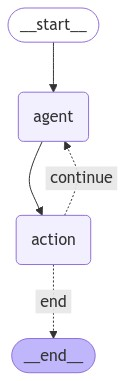

In [347]:
def draw_graph(graph: CompiledStateGraph):
    display(Image(graph.get_graph().draw_mermaid_png()))

draw_graph(chat_graph)

In [348]:
init_msg = [HumanMessage(content="Who is the favoite to win the 2024 US presidential election?")]
async for event in chat_graph.astream({"messages": init_msg}):
    for value in event.values():
        print(value)

{'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2024-09-29T20:43:30.377572Z', 'message': {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'search_tool', 'arguments': {'input': '2024 US presidential election favorite'}}}]}, 'done_reason': 'stop', 'done': True, 'total_duration': 1790306416, 'load_duration': 27429750, 'prompt_eval_count': 267, 'prompt_eval_duration': 1114032000, 'eval_count': 22, 'eval_duration': 647743000}, id='run-242aee72-4cb5-4ffc-8c84-870a71e09d15-0', tool_calls=[{'name': 'search_tool', 'args': {'input': '2024 US presidential election favorite'}, 'id': '641dfdbd-50a1-414c-aa23-6ceb327921e6', 'type': 'tool_call'}], usage_metadata={'input_tokens': 267, 'output_tokens': 22, 'total_tokens': 289})]}
{'name': 'search_tool', 'args': {'input': '2024 US presidential election favorite'}, 'id': '641dfdbd-50a1-414c-aa23-6ceb327921e6', 'type': 'tool_call'}


/var/folders/k9/fclgtm1j483d4r4tbjfzpz1w0000gn/T/ipykernel_5603/1967508518.py:40: LangGraphDeprecationWarning: ToolInvocation is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  content=str(await executor.ainvoke(ToolInvocation(


ValidationError: 1 validation error for TavilyInput
  Input should be a valid dictionary or instance of TavilyInput [type=model_type, input_value=ToolInvocation(tool='sear...ial election favorite'}), input_type=ToolInvocation]
    For further information visit https://errors.pydantic.dev/2.8/v/model_type